# Hotel Cancellations: Simple Starter

In [ ]:
 # download the data
!gdown 1sE0if28EBi8REKa8w0mFiA2XH8udIL1C

Downloading...
From: https://drive.google.com/uc?id=1sE0if28EBi8REKa8w0mFiA2XH8udIL1C
To: /content/hotel_booking_cancellations.csv
100% 16.9M/16.9M [00:00<00:00, 46.6MB/s]


In [ ]:
!pip install catboost
!pip install xgboost
!pip install lightgbm

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import numpy as np

In [ ]:
df = pd.read_csv('hotel_booking_cancellations.csv')
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


# Data Analysis

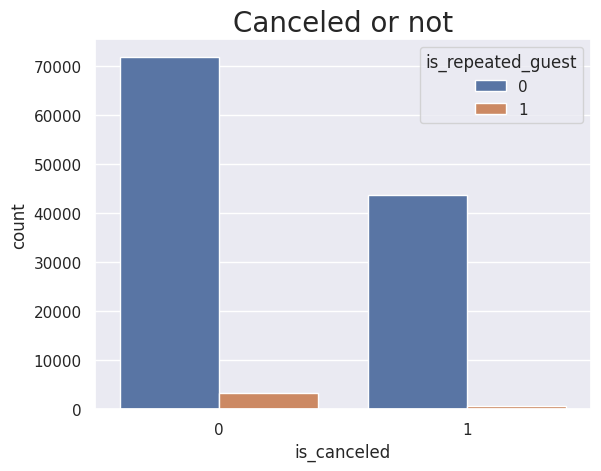

In [ ]:
sns.set(style = "darkgrid")
plt.title("Canceled or not", fontdict = {'fontsize': 20})
ax = sns.countplot(x = "is_canceled", hue = 'is_repeated_guest', data = df)

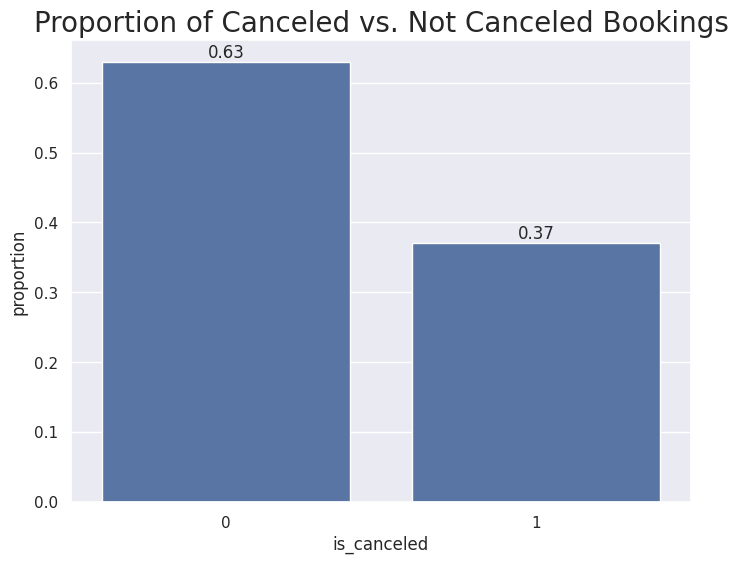

In [ ]:
sns.set(style = "darkgrid")
plt.figure(figsize=(8, 6))
plt.title("Proportion of Canceled vs. Not Canceled Bookings", fontdict={'fontsize': 20})
proportions = df['is_canceled'].value_counts(normalize=True).reset_index()
proportions.columns = ['is_canceled', 'proportion']
ax = sns.barplot(x='is_canceled', y='proportion', data=proportions)
ax.bar_label(ax.containers[0], fmt='%.2f')
plt.show()

In [ ]:
df.groupby('is_canceled').size() / df.shape[0]

,0
is_canceled,
0,0.629584
1,0.370416


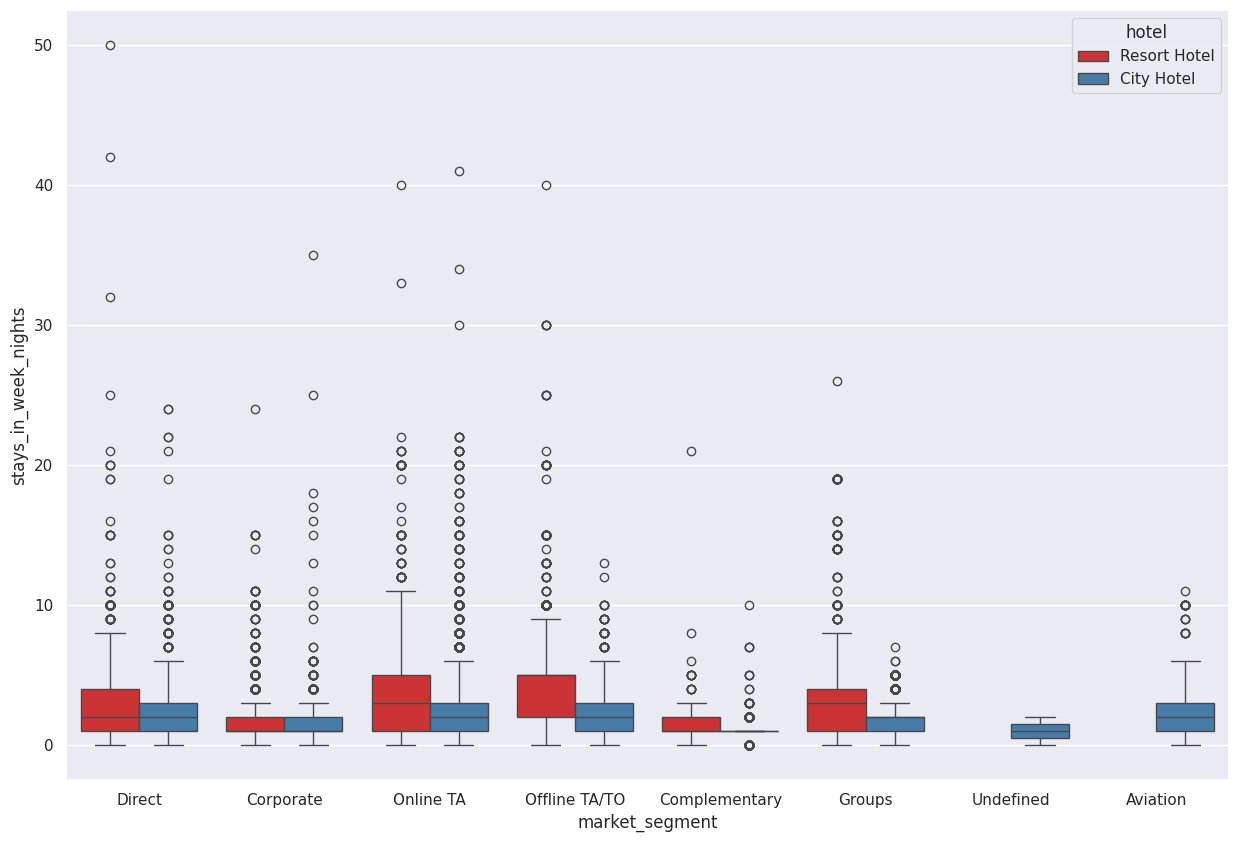

In [ ]:
plt.figure(figsize = (15,10))
sns.boxplot(x = "market_segment", y = "stays_in_week_nights", data = df, hue = "hotel", palette = 'Set1');

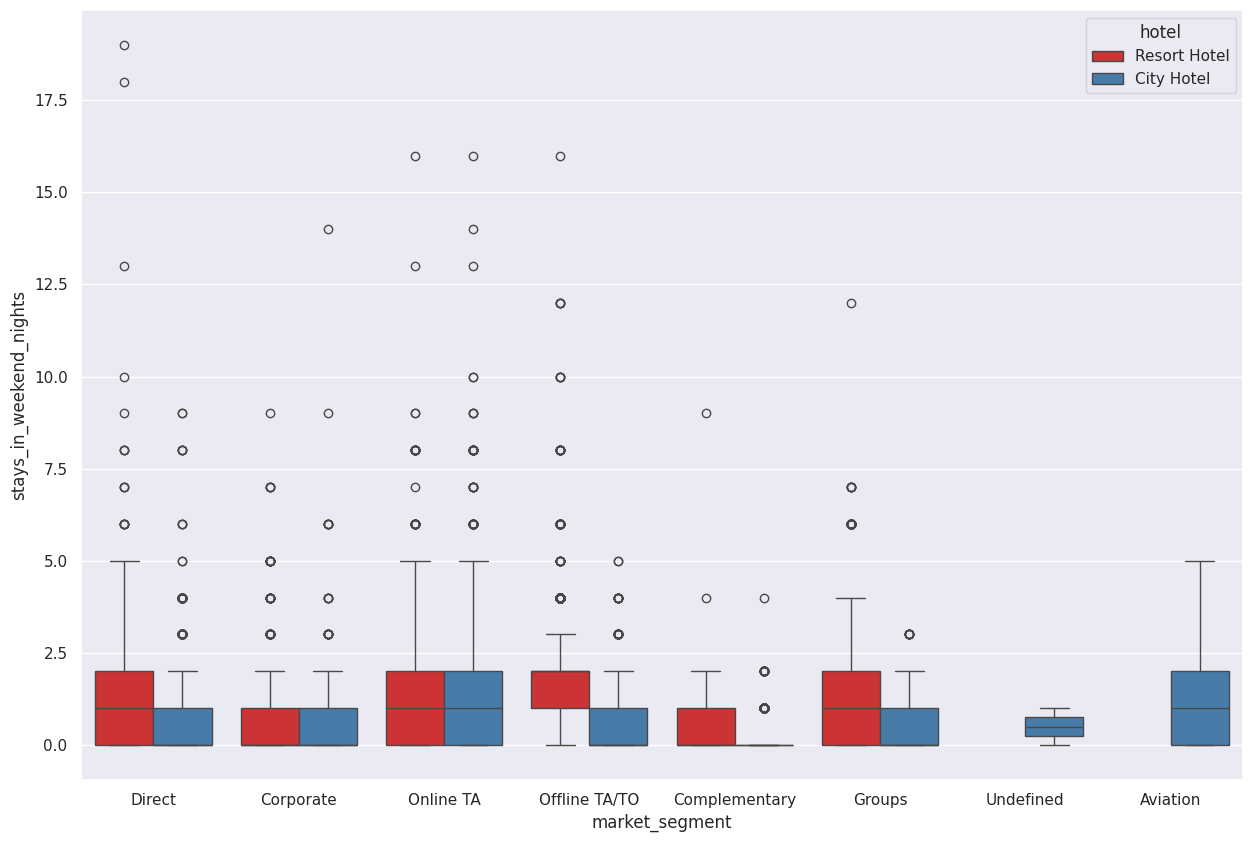

In [ ]:
plt.figure(figsize=(15,10))
sns.boxplot(x = "market_segment", y = "stays_in_weekend_nights", data = df, hue = "hotel", palette = 'Set1');

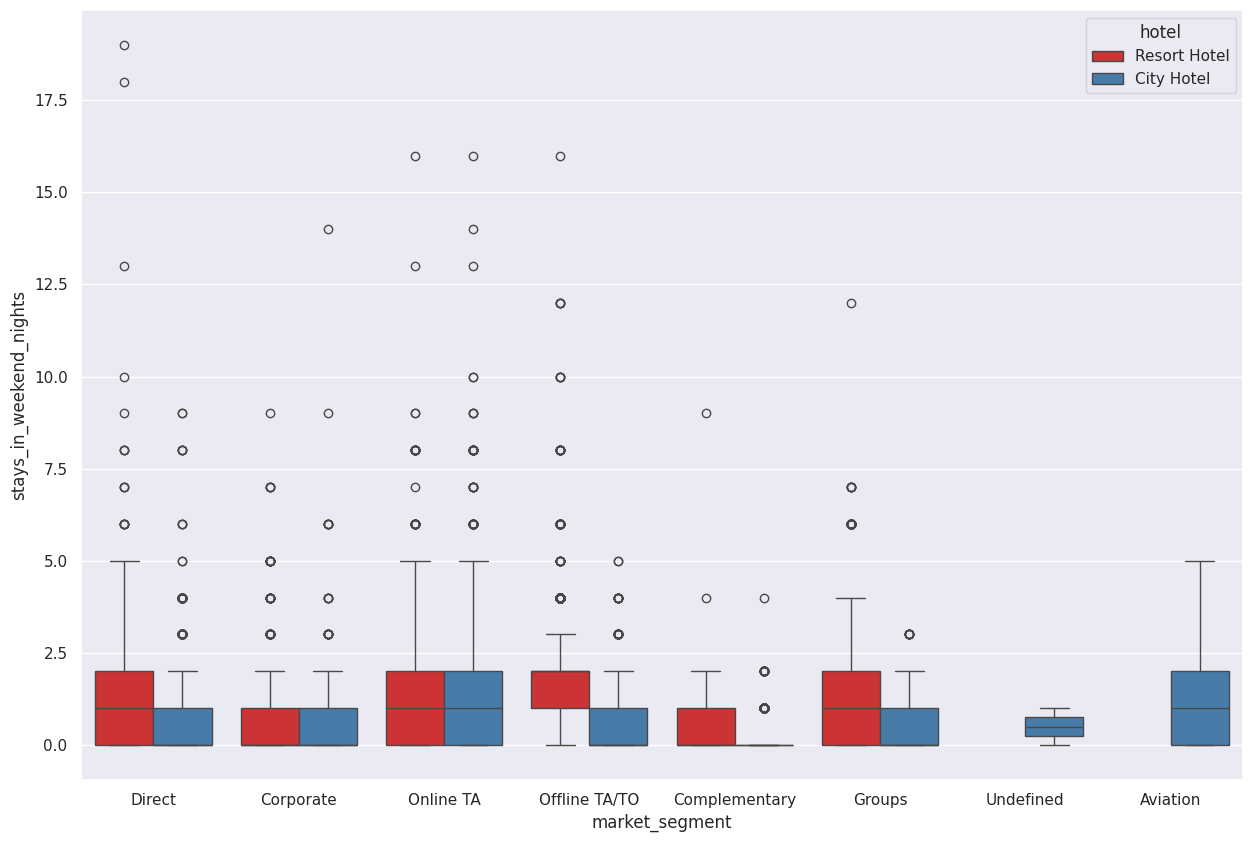

In [ ]:
plt.figure(figsize=(15,10))
sns.boxplot(x = "market_segment", y = "stays_in_weekend_nights", data = df, hue = "hotel", palette = 'Set1');

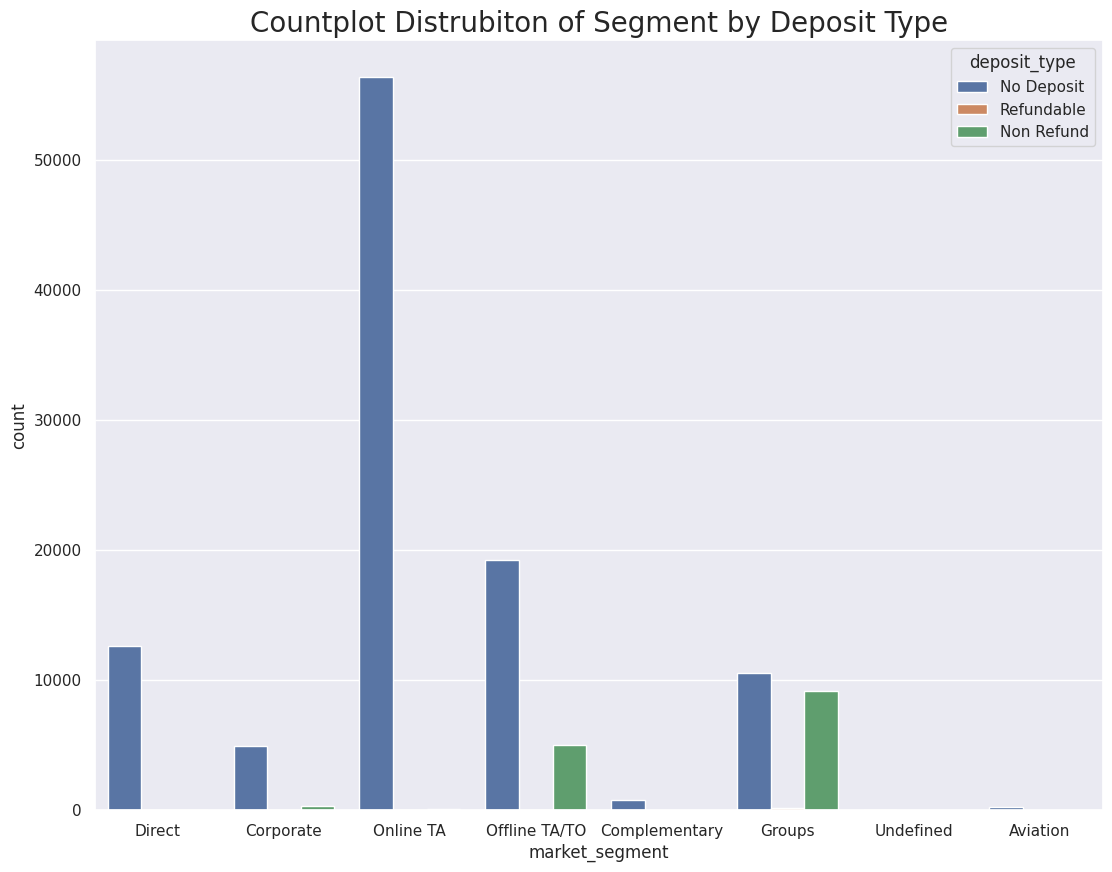

In [ ]:
plt.figure(figsize = (13,10))
sns.set(style = "darkgrid")
plt.title("Countplot Distrubiton of Segment by Deposit Type", fontdict = {'fontsize':20})
ax = sns.countplot(x = "market_segment", hue = 'deposit_type', data = df)

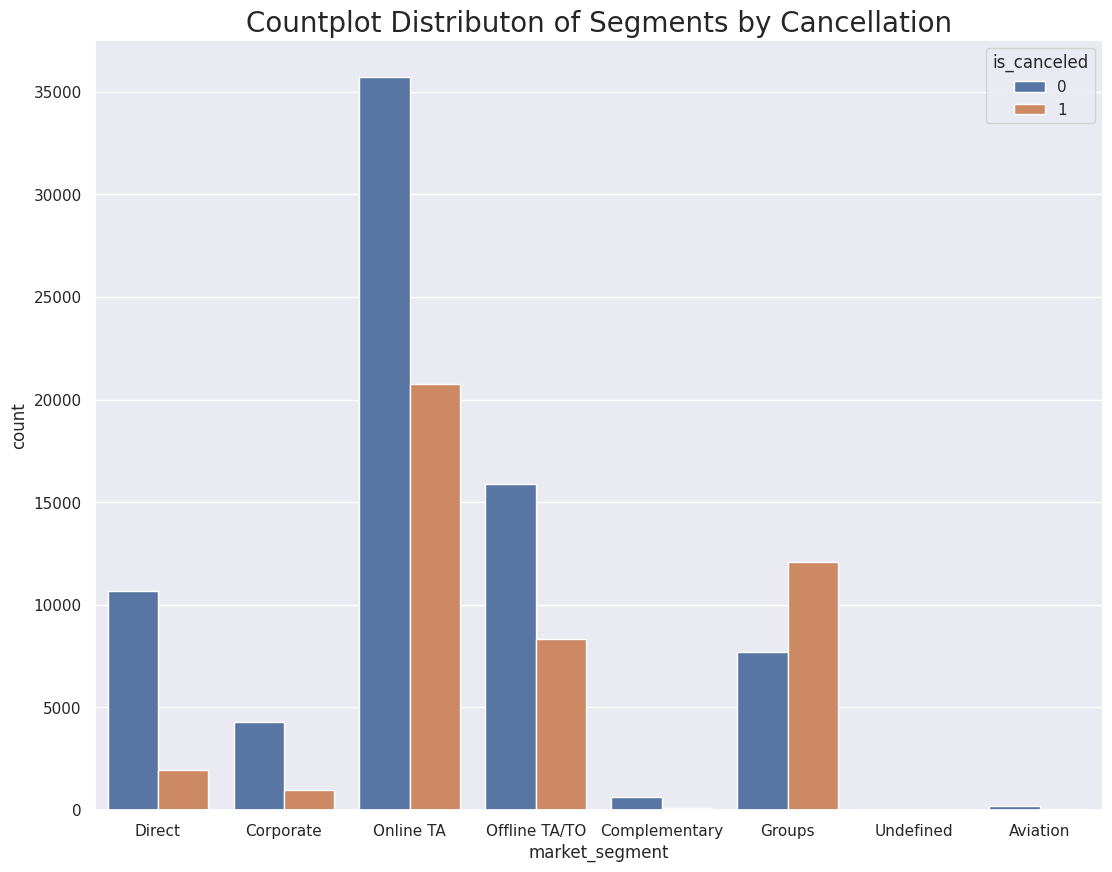

In [ ]:
plt.figure(figsize = (13,10))
sns.set(style = "darkgrid")
plt.title("Countplot Distributon of Segments by Cancellation", fontdict = {'fontsize':20})
ax = sns.countplot(x = "market_segment", hue = 'is_canceled', data = df)

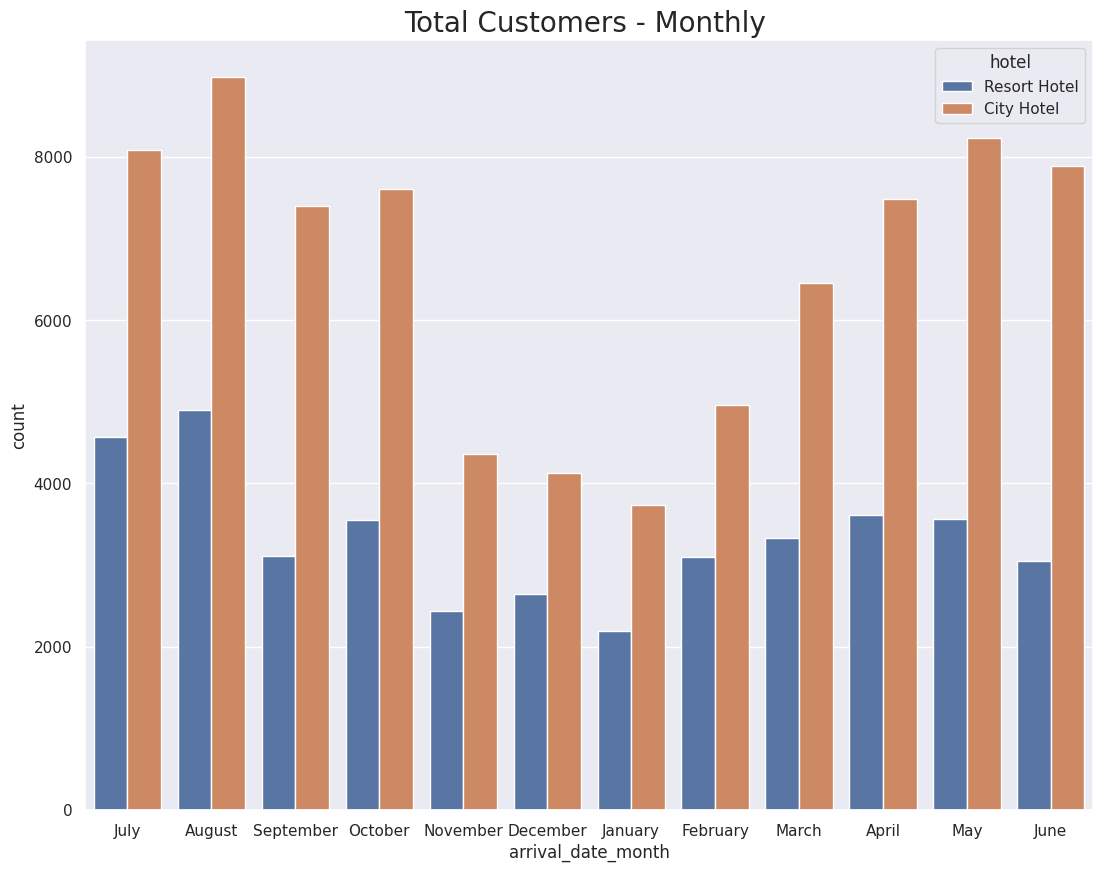

In [ ]:
plt.figure(figsize =(13,10))
sns.set(style="darkgrid")
plt.title("Total Customers - Monthly ", fontdict={'fontsize': 20})
ax = sns.countplot(x = "arrival_date_month", hue = 'hotel', data = df)

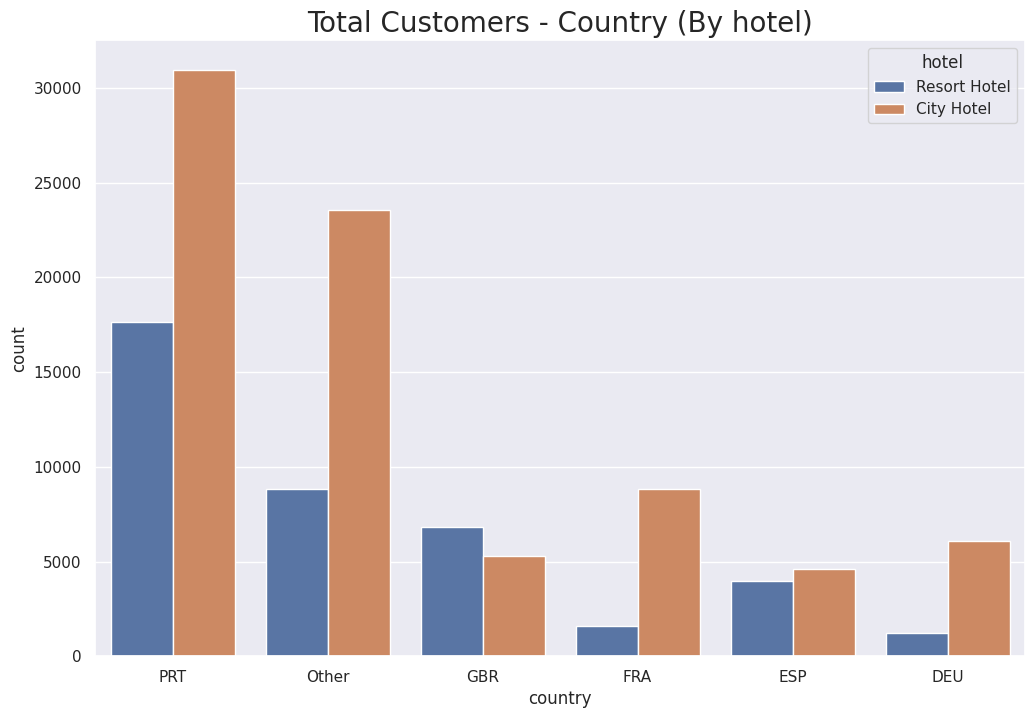

In [ ]:
top_5_countries = df['country'].value_counts().head(5).index
df_plot = df.copy()
df_plot.loc[~df_plot['country'].isin(top_5_countries), 'country'] = 'Other'
plt.figure(figsize=(12, 8))
sns.set(style="darkgrid")
plt.title("Total Customers - Country (By hotel)", fontdict={'fontsize': 20})
plot_order = df_plot['country'].value_counts().index
ax = sns.countplot(x="country", hue='hotel', data=df_plot, order=plot_order)

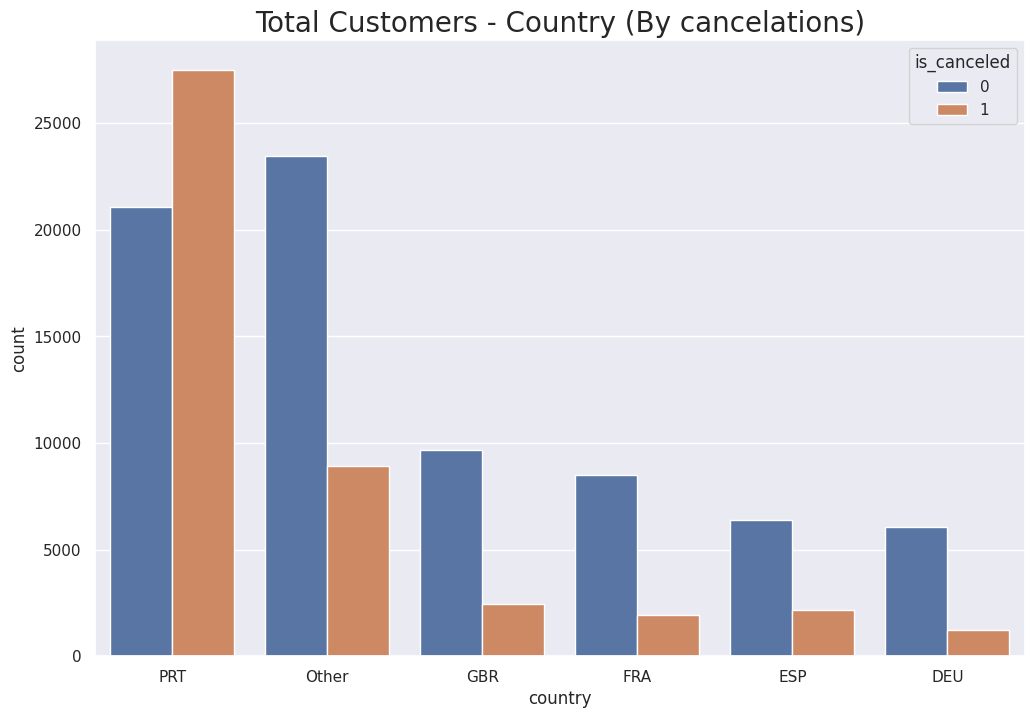

In [ ]:
top_5_countries = df['country'].value_counts().head(5).index
df_plot = df.copy()
df_plot.loc[~df_plot['country'].isin(top_5_countries), 'country'] = 'Other'
plt.figure(figsize=(12, 8))
sns.set(style="darkgrid")
plt.title("Total Customers - Country (By cancelations)", fontdict={'fontsize': 20})
plot_order = df_plot['country'].value_counts().index
ax = sns.countplot(x="country", hue='is_canceled', data=df_plot, order=plot_order)

# Data Preprocessing

In [ ]:
def perc_mv(x, y):
    perc = y.isnull().sum() / len(x) * 100
    return perc

print('Missing value ratios:\nCompany: {}\nAgent: {}\nCountry: {}'.format(perc_mv(df, df['company']),
                                                                                   perc_mv(df, df['agent']),
                                                                                   perc_mv(df, df['country'])))

Missing value ratios:
Company: 94.30689337465449
Agent: 13.686238378423655
Country: 0.40874445095904177


In [ ]:
df["agent"].value_counts().count()

np.int64(333)

In [ ]:
df.drop(['company'], axis = 1, inplace=True)

In [ ]:
df['children'] = df['children'].fillna(0)

In [ ]:
df['hotel'] = df['hotel'].map({'Resort Hotel':0, 'City Hotel':1})

df['arrival_date_month'] = df['arrival_date_month'].map({'January':1, 'February': 2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7,
                                                            'August':8, 'September':9, 'October':10, 'November':11, 'December':12})

In [ ]:
def family(data):
    if ((data['adults'] > 0) & (data['children'] > 0)):
        val = 1
    elif ((data['adults'] > 0) & (data['babies'] > 0)):
        val = 1
    else:
        val = 0
    return val

def deposit(data):
    if ((data['deposit_type'] == 'No Deposit') | (data['deposit_type'] == 'Refundable')):
        return 0
    else:
        return 1

In [ ]:
def feature(data):
    data["is_family"] = data.apply(family, axis = 1)
    data["total_customer"] = data["adults"] + data["children"] + data["babies"]
    data["deposit_given"] = data.apply(deposit, axis=1)
    data["total_nights"] = data["stays_in_weekend_nights"]+ data["stays_in_week_nights"]
    return data

df = feature(df)

In [ ]:
df = df.drop(columns = ['adults', 'babies', 'children', 'deposit_type', 'reservation_status_date', 'reservation_status'])

In [ ]:
le = LabelEncoder()

In [ ]:
cor_data = df.copy()

In [ ]:
cor_data['meal'] = le.fit_transform(cor_data['meal'])
cor_data['distribution_channel'] = le.fit_transform(cor_data['distribution_channel'])
cor_data['reserved_room_type'] = le.fit_transform(cor_data['reserved_room_type'])
cor_data['assigned_room_type'] = le.fit_transform(cor_data['assigned_room_type'])
cor_data['agent'] = le.fit_transform(cor_data['agent'])
cor_data['customer_type'] = le.fit_transform(cor_data['customer_type'])
cor_data['market_segment'] = le.fit_transform(cor_data['market_segment'])

In [ ]:
cor_data.drop(columns='country').corr()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,meal,...,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,is_family,total_customer,deposit_given,total_nights
hotel,1.000000,0.136531,0.075381,0.035267,0.001817,0.001270,-0.001862,-0.186596,-0.234020,0.008018,...,-0.559692,0.072432,0.047531,0.096719,-0.218873,-0.043390,-0.058306,-0.040821,0.172003,-0.247479
is_canceled,0.136531,1.000000,0.293123,0.016660,0.011022,0.008148,-0.006130,-0.001791,0.024765,-0.017678,...,-0.130010,0.054186,-0.068140,0.047557,-0.195498,-0.234658,-0.013010,0.046522,0.481457,0.017779
lead_time,0.075381,0.293123,1.000000,0.040142,0.131424,0.126871,0.002268,0.085671,0.165799,0.000349,...,-0.183373,0.170084,0.073403,-0.063077,-0.116451,-0.095712,-0.043972,0.072265,0.380179,0.157167
arrival_date_year,0.035267,0.016660,0.040142,1.000000,-0.527739,-0.540561,-0.000221,0.021497,0.030883,0.065840,...,0.035281,-0.056497,-0.006149,0.197580,-0.013684,0.108531,0.052711,0.052127,-0.065963,0.031438
arrival_date_month,0.001817,0.011022,0.131424,-0.527739,1.000000,0.995105,-0.026063,0.018440,0.019212,-0.015205,...,-0.043978,0.019045,-0.029753,0.079315,0.000257,0.028026,0.010427,0.027252,0.008746,0.021536
arrival_date_week_number,0.001270,0.008148,0.126871,-0.540561,0.995105,1.000000,0.066809,0.018208,0.015558,-0.017381,...,-0.042837,0.022933,-0.028432,0.075791,0.001920,0.026149,0.010611,0.025220,0.007773,0.018719
arrival_date_day_of_month,-0.001862,-0.006130,0.002268,-0.000221,-0.026063,0.066809,1.000000,-0.016354,-0.028174,-0.007086,...,0.003976,0.022728,0.012188,0.030245,0.008683,0.003062,0.014710,0.006742,-0.008616,-0.027408
stays_in_weekend_nights,-0.186596,-0.001791,0.085671,0.021497,0.018440,0.018208,-0.016354,1.000000,0.498969,0.045744,...,-0.016722,-0.054151,-0.109220,0.049342,-0.018554,0.072671,0.052306,0.101426,-0.114275,0.762790
stays_in_week_nights,-0.234020,0.024765,0.165799,0.030883,0.019212,0.015558,-0.028174,0.498969,1.000000,0.036742,...,0.014903,-0.002020,-0.127223,0.065237,-0.024859,0.068192,0.050424,0.101665,-0.079999,0.941005
meal,0.008018,-0.017678,0.000349,0.065840,-0.015205,-0.017381,-0.007086,0.045744,0.036742,1.000000,...,-0.113765,-0.007132,0.044658,0.059098,-0.038923,0.023136,-0.041727,-0.005975,-0.090725,0.045277


In [ ]:
cor_data.drop(columns='country').corr()["is_canceled"].sort_values()

,is_canceled
total_of_special_requests,-0.234658
required_car_parking_spaces,-0.195498
assigned_room_type,-0.176028
booking_changes,-0.144381
agent,-0.130010
is_repeated_guest,-0.084793
customer_type,-0.068140
reserved_room_type,-0.061282
previous_bookings_not_canceled,-0.057358
meal,-0.017678


In [ ]:
cor_data = cor_data.drop(columns = ['total_nights', 'arrival_date_week_number', 'stays_in_weekend_nights', 'arrival_date_month', 'agent'], axis = 1)

In [ ]:
indices = cor_data.loc[pd.isna(cor_data["country"]), :].index
cor_data = cor_data.drop(cor_data.index[indices])
cor_data.isnull().sum()

,0
hotel,0
is_canceled,0
lead_time,0
arrival_date_year,0
arrival_date_day_of_month,0
stays_in_week_nights,0
meal,0
country,0
market_segment,0
distribution_channel,0


In [ ]:
indices = df.loc[pd.isna(df["country"]), :].index
df = df.drop(df.index[indices])
df = df.drop(columns = ['arrival_date_week_number', 'stays_in_weekend_nights', 'arrival_date_month', 'agent'], axis = 1)

In [ ]:
df1 = df.copy()

In [ ]:
df1 = pd.get_dummies(data = df1, columns = ['meal', 'market_segment', 'distribution_channel',
                                            'reserved_room_type', 'assigned_room_type', 'customer_type'])

In [ ]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_day_of_month,stays_in_week_nights,meal,country,market_segment,distribution_channel,...,booking_changes,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,is_family,total_customer,deposit_given,total_nights
0,0,0,342,2015,1,0,BB,PRT,Direct,Direct,...,3,0,Transient,0.0,0,0,0,2.0,0,0
1,0,0,737,2015,1,0,BB,PRT,Direct,Direct,...,4,0,Transient,0.0,0,0,0,2.0,0,0
2,0,0,7,2015,1,1,BB,GBR,Direct,Direct,...,0,0,Transient,75.0,0,0,0,1.0,0,1
3,0,0,13,2015,1,1,BB,GBR,Corporate,Corporate,...,0,0,Transient,75.0,0,0,0,1.0,0,1
4,0,0,14,2015,1,2,BB,GBR,Online TA,TA/TO,...,0,0,Transient,98.0,0,1,0,2.0,0,2


In [ ]:
df1['country'] = le.fit_transform(df1['country'])

# Modeling

In [ ]:
y = df1["is_canceled"]
X = df1.drop(["is_canceled"], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.25, random_state=42)

## Random Forest

In [ ]:
rfc = RandomForestClassifier(n_estimators = 100, random_state=42)
rfc.fit(X_train, y_train)

y_test_pred = rfc.predict(X_test)
y_pred_proba = rfc.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_test_pred, digits=4))
auc = roc_auc_score(y_test, y_test_pred)
auc1 = roc_auc_score(y_test, y_pred_proba)
print("roc_auc", auc, ' ',auc1)

              precision    recall  f1-score   support

           0     0.8897    0.9369    0.9127     18687
           1     0.8827    0.8033    0.8411     11039

    accuracy                         0.8873     29726
   macro avg     0.8862    0.8701    0.8769     29726
weighted avg     0.8871    0.8873    0.8861     29726

roc_auc 0.8701208231048659   0.9537336388454052


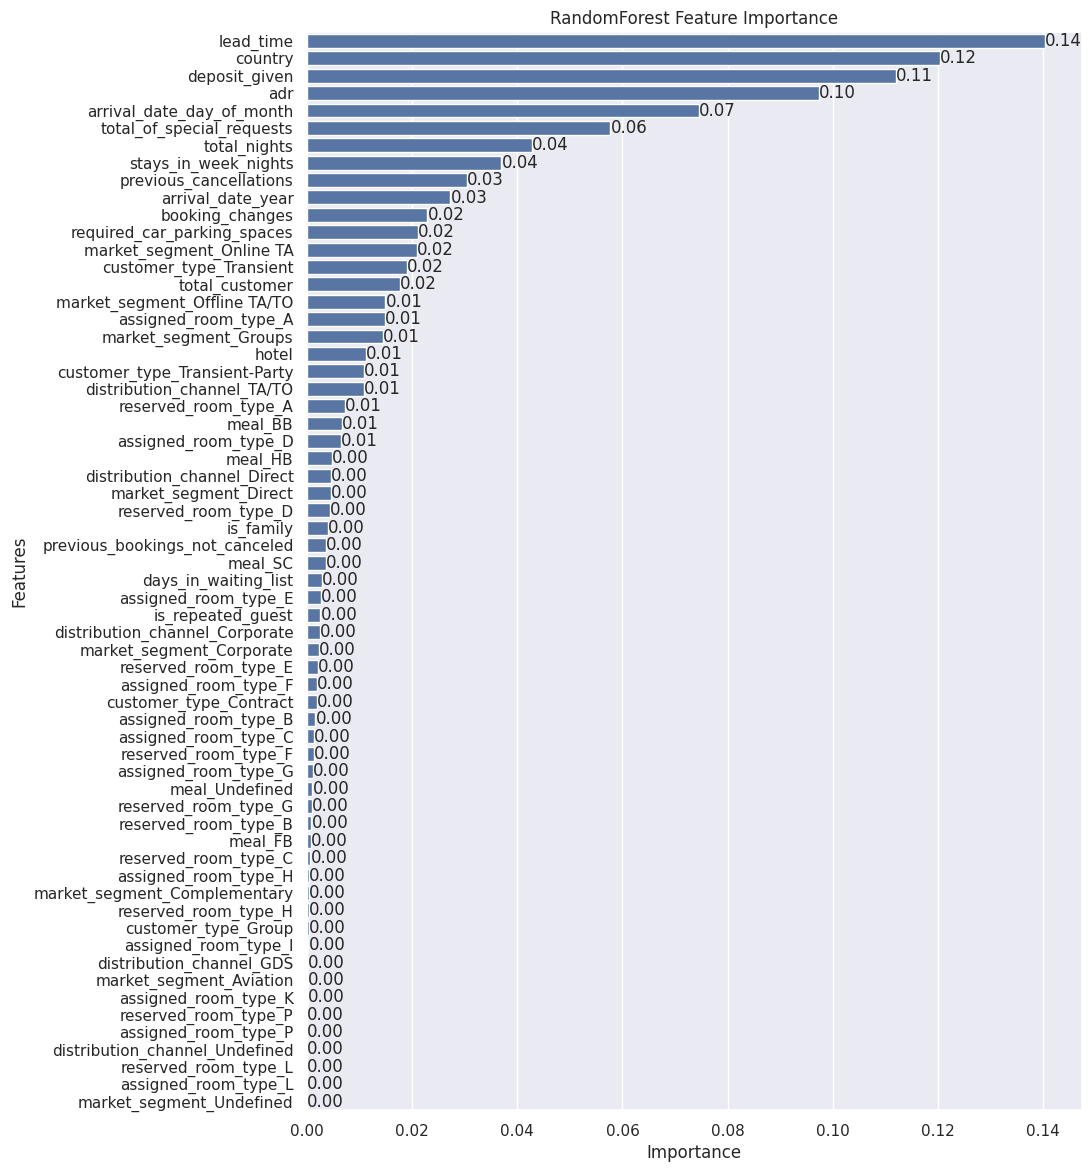

In [ ]:
feature_importance_df = pd.DataFrame({
    'feature_names': X.columns,
    'feature_importance': rfc.feature_importances_
})
feature_importance_df = feature_importance_df.sort_values(by='feature_importance', ascending=False)

plt.figure(figsize=(10, 14))
ax = sns.barplot(x='feature_importance', y='feature_names', data=feature_importance_df)
ax.bar_label(ax.containers[0], fmt='%.2f')
plt.title('RandomForest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

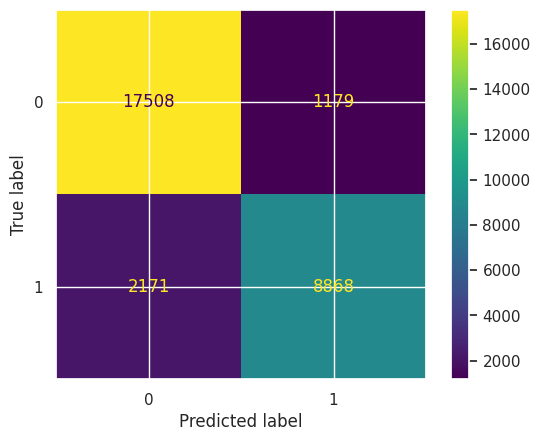

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred > 0.5))
disp.plot()

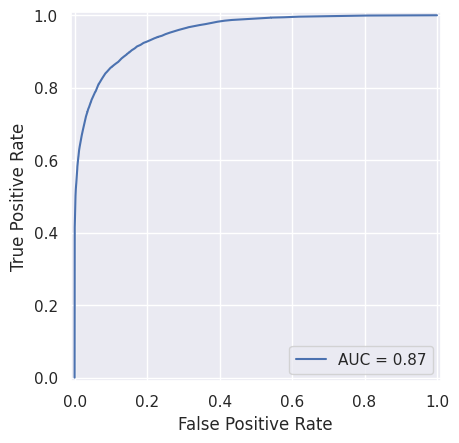

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc)
disp.plot()

## Decision Tree

In [ ]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

y_test_pred = dtc.predict(X_test)

print(classification_report(y_test, y_test_pred, digits=4))
print("roc_auc", roc_auc_score(y_test, y_test_pred))


              precision    recall  f1-score   support

           0     0.8804    0.8678    0.8741     18687
           1     0.7815    0.8004    0.7909     11039

    accuracy                         0.8428     29726
   macro avg     0.8310    0.8341    0.8325     29726
weighted avg     0.8437    0.8428    0.8432     29726

roc_auc 0.834128686215439


## CatBoost

In [ ]:
cbc = CatBoostClassifier(
    iterations=200,
    depth=8,
    verbose=10
)
cbc.fit(X_train, y_train)

y_test_pred = cbc.predict(X_test)
y_pred_proba = rfc.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_test_pred, digits=4))
print("roc_auc", roc_auc_score(y_test, y_test_pred))
print("roc_auc_proba", roc_auc_score(y_test, y_pred_proba))

Learning rate set to 0.306652
0:	learn: 0.4675630	total: 49.1ms	remaining: 9.77s
10:	learn: 0.3268841	total: 955ms	remaining: 16.4s
20:	learn: 0.3074512	total: 1.62s	remaining: 13.8s
30:	learn: 0.2966272	total: 2.17s	remaining: 11.8s
40:	learn: 0.2876255	total: 2.52s	remaining: 9.78s
50:	learn: 0.2798863	total: 2.85s	remaining: 8.32s
60:	learn: 0.2735153	total: 3.16s	remaining: 7.2s
70:	learn: 0.2665895	total: 3.49s	remaining: 6.35s
80:	learn: 0.2614379	total: 3.85s	remaining: 5.66s
90:	learn: 0.2561103	total: 4.17s	remaining: 4.99s
100:	learn: 0.2511284	total: 4.5s	remaining: 4.41s
110:	learn: 0.2466541	total: 4.84s	remaining: 3.88s
120:	learn: 0.2427572	total: 5.16s	remaining: 3.37s
130:	learn: 0.2387567	total: 5.49s	remaining: 2.89s
140:	learn: 0.2354967	total: 5.84s	remaining: 2.44s
150:	learn: 0.2326509	total: 6.14s	remaining: 1.99s
160:	learn: 0.2300218	total: 6.46s	remaining: 1.56s
170:	learn: 0.2271461	total: 6.8s	remaining: 1.15s
180:	learn: 0.2238971	total: 7.12s	remaining: 7

## XGBoost

In [ ]:
xgb = XGBClassifier(booster = 'gbtree', learning_rate = 0.1, max_depth = 5, n_estimators = 180)
xgb.fit(X_train, y_train)

y_test_pred = xgb.predict(X_test)

print(classification_report(y_test, y_test_pred, digits=4))
print("roc_auc", roc_auc_score(y_test, y_test_pred))

              precision    recall  f1-score   support

           0     0.8716    0.9151    0.8928     18687
           1     0.8430    0.7718    0.8058     11039

    accuracy                         0.8619     29726
   macro avg     0.8573    0.8434    0.8493     29726
weighted avg     0.8610    0.8619    0.8605     29726

roc_auc 0.8434418457503761


## LightGBM (!Best score!)


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'num_leaves': [31, 50, 70],
    'learning_rate': [0.1, 0.05, 0.01],
    'n_estimators': [200, 500, 1000]
}

lgbm = LGBMClassifier(random_state=42)

grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid,
                           scoring='roc_auc', cv=3, verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

best_lgbm = LGBMClassifier(**best_params, random_state=42)
best_lgbm.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 33118, number of negative: 56058
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1014
[LightGBM] [Info] Number of data points in the train set: 89176, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.371378 -> initscore=-0.526310
[LightGBM] [Info] Start training from score -0.526310
Best parameters found: {'learning_rate': 0.05, 'n_estimators': 1000, 'num_leaves': 70}
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 33118, number of negative: 56058
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030679 seconds.
You can set `force_row_

LGBMClassifier(learning_rate=0.05, n_estimators=1000, num_leaves=70,
               random_state=42)

In [ ]:
lgbm = LGBMClassifier(random_state=42, n_estimators=1000, learning_rate=0.05, num_leaves=70)
lgbm.fit(X_train, y_train)

y_test_pred = best_lgbm.predict(X_test)
y_pred_proba = best_lgbm.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_test_pred, digits=4))
auc = roc_auc_score(y_test, y_pred_proba)
print("roc_auc", auc)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 33118, number of negative: 56058
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1014
[LightGBM] [Info] Number of data points in the train set: 89176, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.371378 -> initscore=-0.526310
[LightGBM] [Info] Start training from score -0.526310
              precision    recall  f1-score   support

           0     0.8927    0.9245    0.9084     18687
           1     0.8641    0.8119    0.8372     11039

    accuracy                         0.8827     29726
   macro avg     0.8784    0.8682    0.8728     29726
weighted avg     0.8821    0.8827    0.8819     29726

roc_auc 0.9535865152865859


In [ ]:
feature_importance_df = pd.DataFrame({
    'feature_names': X.columns,
    'feature_importance': lgbm.feature_importances_
})
feature_importance_df = feature_importance_df.sort_values(by='feature_importance', ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='feature_importance', y='feature_names', data=feature_importance_df)
ax.bar_label(ax.containers[0], fmt='%.2f')
plt.title('LightGBM Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred > 0.5))
disp.plot()

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc)
disp.plot()